In [2]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.integrate import quad
import scipy.stats
from time import time
from mpl_toolkits.mplot3d import Axes3D as ax

# Class FinanceToys

In [3]:
class FinanceToys():
    """
    Where some usefull methods are stocked
    """
    def correl2prices(self,S0,Y0,t,r,sigma1,sigma2,T, rho):
        """
        Tow correlated variable simulation with mean = S0 and std = sigma*sqrt(T-t).
        Args : 
            S0 (double) : spot price of first stock
            Y0 (double) : spot price of 2nd stock
            t (double) : time spot
            r (double) : interest rate 
            sigma1 (double) : volatility of first stock
            sigma2 (double) : volatility of 2nd stock
            T (double) : maturity
            rho : correlation between the two stocks
        Return : 
            (ST,YT) (tuple): the two prices in a tuple 
        """
        W1 = np.random.normal(0, 1)
        W2 = np.random.normal(0, 1)
        return (S0*np.exp((r-0.5*self.sigma**2)+self.sigma*np.sqrt(T-t)*W1), 
               Y0*np.exp((r-0.5*sigma2**2)+sigma2*np.sqrt(T-t)*(rho*W1+np.sqrt(1-rho)*W2)))
        
    def gaussiancumulative(self,a):
        """
        Gaussian cumulative function.
        Args : 
            a (double) : bound for the cumulative function
        Return : 
            y (double): list of values of the random walk trajectory simulated  
        """
        try:
            return quad(lambda x: np.exp((-x**2)/2)/np.sqrt(2*np.pi), -np.inf, a)
        except:
            return np.array([[quad(lambda x: np.exp((-x**2)/2)/np.sqrt(2*np.pi), -np.inf, b)[0] for b in aliste ]for aliste in a])
    
    def price(self,payoff,vol=None):
        """
        Pricer using montecarlo method for estimate vanilla price of optionswith one underliying
        Args : 
            payoff (Payoff) : payoff method from class Payoff
            spot (double) : spot price of the underliying 
            K (double) : Strike 
            rate (double) : interest rate
            sigma (double) : barrier down
            time_spot (double) : time spot (years)
            maturity (double) : time of maturity (years)
            nb_steps (int) : number of step in each brownian trajectory simulation 
            nb_sim (int) : number of simulation of trajectory
            alpha (double) : stastistical alpha for tje confidence interval
            model (string) : the model of pricing

        Return :
            (price, [C1,C2], time) (tuple): tuple containe price, confidence interval and time of calulation  
        """
        esp = 0
        espsquare = 0
        q_alpha = scipy.stats.norm.ppf(self.alpha)
        start=time()
        for i in self.generator(self.nb_sim):
            X = self.ST()
            esp += payoff(X,self.K)
            espsquare += payoff(X,self.K)**2
        esp = np.exp(-self.r*(self.T-self.t))*esp/self.nb_sim
        var = (1/(self.nb_sim-1))*espsquare*np.exp(-self.r*(self.T-self.t))-(self.nb_sim/(self.nb_sim-1))*(esp**2)
        confidence = [esp-q_alpha*np.sqrt(var/self.nb_sim),esp+q_alpha*np.sqrt(var/self.nb_sim)]
        end=time()-start
        return(esp, confidence, end)

# Class Payoff

In [4]:
class Payoff():
    """
    This class gives some classical payoffs functions taking stock price at maturity an strike in input for vailla options and 
    all the trajectory of the stock and the strike for exotic options and return the payoff. Can be use for ploting payoffs 
    against strike or price, but also for princing option by montecarlo methods. For simplification, all payoffs have the same 
    args input but in some case, some inputs are useless for the option (ex: barrier for a simple call), in this case it will 
    be initialized by None.
    """
    #Vanilla 
    def call(self,ST,K,YT=None,B_up=None, B_down=None, rho=None):
        """
        Call payoff.
        Args : 
            ST (double) : final price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        return max(ST-K,0)
    
    def put(self,ST,K,YT=None,B_up=None, B_down=None, rho=None):
        """
        Put payoff.
        Args : 
            ST (double) : final price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        return max(K-ST,0)
    
    def digital(self,ST,K=1,YT=None,B_up=None, B_down=None, rho=None):
        """
        Binar option payoff.
        Args : 
            ST (double) : final price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if ST>K:
            return K
        return 0
    
    def bestofcall(self,ST,K,YT,B_up=None, B_down=None, rho=0):
        """
        Best of call payoff.
        Args : 
            ST (double) : final price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        H = correl2prices(1,ST,YT,rho,self.sigma)
        return max(max(H[0],H[1])-K,0)
    
    #Exotics (path dependent options), here S is the list of all the prices of the underlying befor maturity.
    def asian(self,S,K,YT=None,B_up=None, B_down=None, rho=None):
        """
        Asian option payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        return max(np.mean(S)-K,0)
    
    #Barriers options
    def UIC(self,S,K=1,YT=None,B_up=110, B_down=110, rho=None):
        """
        UIC payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if max(S)>=B_up:
            return max(S[-1]-K, 0)
        return 0
    
    def UIP(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        UIP payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if max(S)>=B_up:
            return max(K-S[-1], 0)
        return 0
    
    def UOC(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        UOC payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if max(S)>=B_up:
            return 0
        return max(S[-1]-K, 0)
    
    def UOP(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        UOP payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if max(S)>=B_up:
            return 0
        return max(K-S[-1], 0)
    
    def DIC(self,S,K=1,YT=1,B_up=110, B_down=90, rho=None):
        """
        DIC payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        print(S)
        if min(S)<=B_down:
            return max(S[-1]-K, 0)
        return 0
    
    def DIP(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        DIP payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if min(S)<=B_down:
            return max(K-S[-1], 0)
        return 0
    
    def DOC(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        DOC payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if min(S)<=B_down:
            return 0
        return max(S[-1]-K, 0)
    
    def DOP(self,S,K=1,YT=None,B_up=110, B_down=90, rho=None):
        """
        DOP payoff.
        Args : 
            ST (list) : trajectory price
            K (double) : strike 
            YT (double) : 2nd underliying final price (if ther is)
            B_up (double) : barrier up
            B_down (double) : barrier down
        Return : 
            y (double): payoff  
        """
        if min(S)<=B_down:
            return 0
        return max(K-S[-1], 0)

# Class Diffusion

In [5]:
class Diffusion:
    """
        Introduction of some diffusion models as Black Scholes or Heston. 
        There is also some tools for stochastic process generation.
    """    
    def __init__(self):
        self.mu = 0.05
        self.sigma = 0.3

    
    def generator(self,n):
        """
        Fonction to build an interator.
        Args : 
            n (int) : number of iteration needed
        Return : 
            iter (iterator): iterator  
        """
        for i in range(n):
            yield i+1
        
    def brownianmotion(self, nb_steps=1000, nb_years=1):
        """
        Brownian motion simulation.
        Args : 
            nb_steps (int) : number of values one want to simulate between 0 and the bound
            nb_years (int) : bound of time
        Return : 
            [x1, ...,xn] (list): list of values of the brownian trajectory simulated  
        """
        brownian_values = [0]
        for i in self.generator(nb_steps):
            brownian_values.append(brownian_values[-1]+np.sqrt(nb_years/nb_steps)*np.random.normal(0, 1))
        return brownian_values
    
    def randomwalk(self, nb_steps=1000):
        """
        Random walk simulation.
        Args : 
            nb_steps (int) : number of values one want to simulate between 0 and the bound
        Return : 
            [x1, ...,xn] (list): list of values of the random walk trajectory simulated  
        """
        randomwalk_values = [self.S0]
        for i in self.generator(nb_steps):
            randomwalk_values.append(randomwalk_values[-1]+random.choice([-1, 1]))
        return randomwalk_values
    
    def itodiffusion(self, S0, nb_steps, nb_years, b = lambda x,y:0.05*y, s = lambda x,y: 0.3*y):
        """
        Ito diffusion simulation. Discretization : Euler Scheme.
        Args : 
            S0 (int) : begining point of the process
            nb_steps (int) : nuumber of steps in the trajectory simulation
            nb_years (int) : bound of time
            b (function of type f(x,y)->result(double)) : function of drift
            s (function of type f(x,y)->result(double)) : function of volatility
        Return : 
            [x1, ...,xn] (list): list of values of the simulated trajectory  
        """
        W = self.brownianmotion(nb_steps, nb_years)
        ito_values = [S0]
        for i in self.generator(nb_steps):
            ito_values.append(max(ito_values[-1] + b(i/nb_steps,ito_values[-1])*1/nb_steps +
                              s(i/nb_steps,ito_values[-1])*(W[i]-W[i-1]),0))
        return ito_values

# Class Option

In [6]:
class Option:
    """
    This class is an abstract class in wich we define all parameters of the option we would to give a price.
    """
    def __init__(self, nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega):
        self.nature = nature
        self.t = time_spot
        self.T = maturity
        self.S0 = spot_price
        self.K = strike
        self.r = rate
        self.d = dividends
        self.P = market_price
        self.v = vega
        
    def generator(self,n):
        """
        Fonction to build an interator.
        Args : 
            n (int) : number of iteration needed
        Return : 
            iter (iterator): iterator  
        """
        for i in range(n):
            yield i+1

# Class BlackScholes

In [58]:
class BlackScholes(Option, FinanceToys):
    """
    Cla
    s wich bring some classical tools of the Black and Scholes model like logprice simulation, close formula for vanilla option or montecarlo algorithme for exotic option pricing 
    but also to compute and plot implied volatility.
    BlackScholes(nature(str), time_spot(double), maturity(double), spot_price(double), strike(double), 
                        rate(double), dividends(double), market_price(double), vega(double), sigma(double))
    """
    def __init__(self,nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega, sigma):
        Option.__init__(self, nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega)
        self.sigma = sigma

    def ST(self, S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None):
        """
        Lognormal variable simulation.
        Args : 
            ST(S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(double,optional), sigma(double,optional), T(double,optional))
        Return : 
            y (double): stock price simulation at time T  
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T
        return S0*np.exp(((r-d)-0.5*sigma**2)*(T-t)+sigma*np.sqrt(T-t)*np.random.normal(0, 1))

    def d1(self,S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None):
        """
        Function d1 in black Scholes model.
        Args : 
            d1(S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(double,optional), sigma(double,optional), T(double,optional))
        Return : 
            y (double): d1 
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T
        return (1/sigma*np.sqrt(T-t)*(np.log(S0/K)+(r+(sigma**2)/2)*(T-t)))

    def d0(self,S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None):
        """
        Function d0 in black Scholes model.
        Args : 
            d0(S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(double,optional), sigma(double,optional), T(double,optional))
        Return : 
            y (double): d0 
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T  
        return self.d1(S0,K,t,r,d,sigma,T)-sigma*np.sqrt(T-t)

    def bs_call(self,S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None):
        """
        Call price in Black Scholes model.
        Args : 
            bs_call(S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(double,optional), sigma(double,optional), T(double,optional))
        Return : 
            y (double): call price  
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T
        return np.exp(-d*(T-t))*S0*self.gaussiancumulative(self.d1(S0,K,t,r,d,sigma,T))[0]-K*np.exp(-r*(T-t))*self.gaussiancumulative(self.d0(S0,K,t,r,d,sigma,T))[0]

    def bs_put(self,S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None):
        """
        Put price in Black Scholes model.
        Args : 
            bs_put(S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(double,optional), sigma(double,optional), T(double,optional))
        Return : 
            y (double): put price  
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T
        return np.exp(-r*(T-t))*K*self.gaussiancumulative(-self.d0(S0,K,t,r,d,sigma,T))[0]-np.exp(-d*(T-t))*S0*self.gaussiancumulative(-self.d1(S0,K,t,r,d,sigma,T))[0]

    def impliedvol(self,callorput,S0=None,K=None,t=None,r=None,d=None,sigma=None,T=None,P=None):
        """
        Implied volatility for one strike and one maturity.
        Args : 
            impliedvol(callorput(string),S0(double,optional), K(double,optional), t(double,optional), r(double,optional), d(doubble,optional), sigma(double,optional), T(double,optional), P(double,optional))
        Return : 
            y (double): implied volatility 
        """
        if S0==None: S0 = self.S0
        if K==None: K = self.K
        if t==None: t = self.t
        if r==None: r = self.r
        if d==None: d = self.d
        if sigma==None: sigma = self.sigma
        if T==None: T = self.T
        if P==None: P = self.P
        if callorput=='call':
            x = 0
            y = 1
            for i in range(100):
                z = 0.5*(x+y)
                if P > self.bs_call(S0,K,t,r,d,z,T):
                    x = z
                else:
                    y = z
            z = (x+y)/2
            return z/(1-z+0.0001)
        
        elif callorput=='put':
            x = 0
            y = 1
            for i in range(100):
                z = 0.5*(x+y)
                if P > self.bs_put(S0,K,t,r,d,z,T):
                    x = z
                else:
                    y = z
            z = (x+y)/2
            return z/(1-z+0.0001)

    def array_impliedvol(self, strikes, maturitys, market_prices):
        """
        Implied volatility for options out of the money for a list of strikes and list of maturitys.
        Args : 
            array_impliedvol(strikes(list[doubles]), maturitys(list[doubles]), market_prices(list[list[doubles]]))
            For market_prices, a 2d list with maturitys in row and strikes in columns.
        Return : 
            M (2d np.array): Matrix of implied volatility 
        """
        IV = []
        for i in range(len(maturitys)):
            IVline = []
            for j in range(len(strikes)):
                if strikes[j] < self.S0:
                    IVline.append(self.impliedvol('put',K=strikes[j],T=maturitys[i],P=market_prices[i][j]))
                else:
                    IVline.append(self.impliedvol('call',K=strikes[j],T=maturitys[i],P=market_prices[i][j]))
            IV.append(IVline)
        return np.array(IV)

    def plot_impliedvol(self, strikes, maturitys, market_prices):
        """
        Plot implied volatility for options out of the money for a list of strikes and list of maturitys.
        Args : 
            array_impliedvol(strikes(list[doubles]), maturitys(list[doubles]), market_prices(list[list[doubles]]))
            For market_prices, a 2d list with maturitys in row and strikes in columns.
        Return : 
            G (plot): Implied volatility graphic
        """
        z =self.array_impliedvol(strikes, maturitys, market_prices)
        strikes = [K*100/self.S0 for K in strikes]
        x, y = np.meshgrid(strikes, maturitys)
        # Normalize to [0,1]
        norm = plt.Normalize(z.min(), z.max())
        colors = cm.rainbow(norm(z))
        rcount, ccount, _ = colors.shape
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax = fig.gca(projection='3d')
        surf = ax.plot_surface(x, y, z, rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False)
        #surf.set_facecolor((1,1,1,1))
        plt.show()

In [33]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

# Class Heston

In [34]:
class Heston(Option,Payoff,Diffusion,FinanceToys):
    """
    Class for pricing option in a Heston model.
    """
    def __init__(self,nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega, sigmavol,
                rho, kappa, theta, initial_variance):
        Option.__init__(self, nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega)
        self.sigmavol = sigmavol
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.initial_variance = initial_variance
        self.nb_step = 10
        self.nb_sim = 100
        self.alpha = 0.95
    
    def ST(self):
        """
        Heston price trajectory simulation.
        Args : 
            vol (double) : put sigma if don't want to use sigma attribut(for IV calcul)
        Return : 
            y (double): price at time T  
        """
        W = self.brownianmotion(self.nb_step, self.T)
        vol_process = self.itodiffusion(self.initial_variance, self.nb_step, self.T, lambda x,y: self.kappa*(self.theta-y), 
                                  lambda x,y: self.sigmavol*np.sqrt(y))
        heston_values = [self.S0]
        for i in self.generator(self.nb_step):
            heston_values.append(heston_values[-1] + self.r*heston_values[-1]*1/self.nb_step +
                              np.sqrt(vol_process[i])*heston_values[-1]*(W[i]-W[i-1]))
        return heston_values
    
    def price(self,payoff,vol=None):
        """
        Pricer using montecarlo method for estimate vanilla price of optionswith one underliying
        Args : 
            payoff (Payoff) : payoff method from class Payoff
            vol (double) : put sigma if don't want to use sigma attribut(for IV calcul)
        Return :
            (price, [C1,C2], time) (tuple): tuple containe price, confidence interval and time of calulation  
        """
        esp = 0
        espsquare = 0
        q_alpha = scipy.stats.norm.ppf(self.alpha)
        start=time()
        for i in self.generator(self.nb_sim):
            X = self.ST()[-1]
            esp += payoff(X,self.K)
            espsquare += payoff(X,self.K)**2
        esp = np.exp(-self.r*(self.T-self.t))*esp/self.nb_sim
        var = (1/(self.nb_sim-1))*espsquare-(self.nb_sim/(self.nb_sim-1))*(esp**2)
        confidence = [esp-q_alpha*np.sqrt(var/self.nb_sim),esp+q_alpha*np.sqrt(var/self.nb_sim)]
        end=time()-start
        return(esp, confidence, end)
    
    def impliedvol(self,payoff,P=None):
        """
        Exctract the implied volatility.
        Args : 
            P (double) : market price
        Return : 
            y (double): imlied volatility
        """
        initial_sigma = self.sigmavol
        if P is None:
            P = self.P
        x=0
        y=1
        for i in self.generator(100):
            self.sigmavol = 0.5*(x+y)
            if P>self.price(payoff)[0]:
                x=self.sigmavol
            else:
                y=self.sigmavol
        z= (x+y)/2
        self.sigmavol=initial_sigma
        return z/(1-z)
    
def plot_impliedvol_heston(payoff, nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega, sigmavol,
                rho, kappa, theta, initial_variance):
    """
    args : 
        nature (str) : 'call' or 'put'
        time_spot (double)
        maturity (liste) : liste des maturités pour la nappe
        spot_price (double):prix spot
        strike (liste) : liste des strikes 
        rate (double)
        div (double)
    """
    start = time()
    IV = []
    for m in range(len(maturity)):
        IV.append([Heston(nature, time_spot, maturity[m], spot_price, strike[s], rate, dividends, market_price[m][s], vega, sigmavol,
                rho, kappa, theta, initial_variance).impliedvol(payoff) for s in range(len(strikes))])
    z = np.array(IV)
    x, y = np.meshgrid(strikes, maturitys)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(x, y, z)
    print(time()-start)
    plt.show()

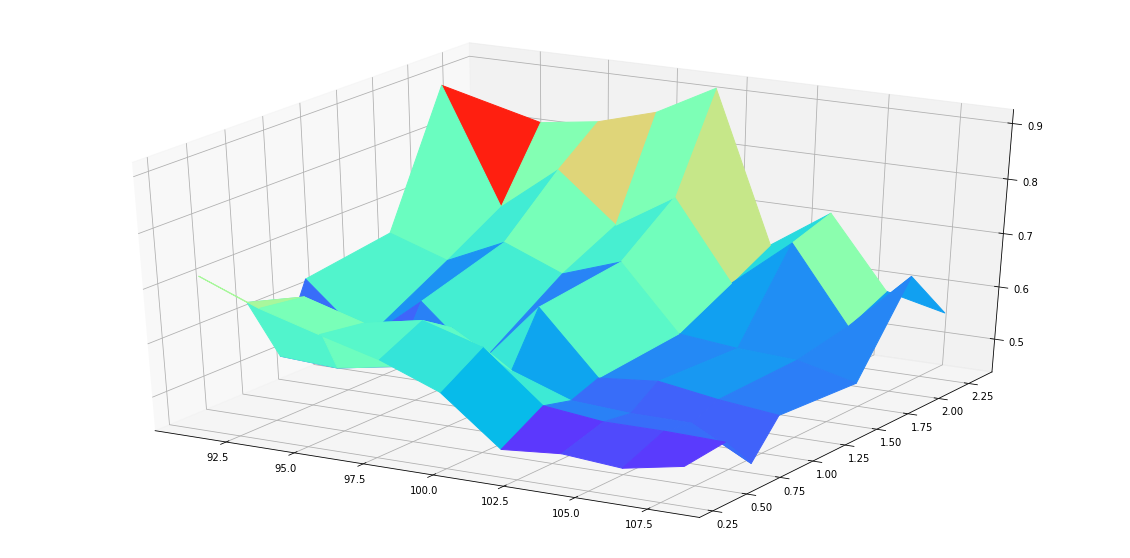

In [59]:
PF = Payoff()
BS = BlackScholes("call", 0, 1, 236, 230, 0.02, 0.01, 10, 0, 0.3)
MP = [[10.06,11.80,13.76,15.81,17.65,15.20,13.33,11.13,9.75],
    [16.70,19.65,21.30,24.40,26.23,23.80,21.35,19.42,17.52],
    [17, 19, 22, 27.4, 28, 27.3,25,23.05,19],
    [24, 23, 28.5, 27.5, 34.5, 31.5, 29.9, 27.3,25],
    [30.6,32, 36.75,38,42.5,40.3,38,36,33],
    [38.18,35,41.18,41.5, 47.35, 45.89, 48.3, 40.85,44.5],
    [34.6,37.5,41.6,46.2,51.5,48.4,50.2,44.15,42]] 
K = [K for K in range(215,260,5)]
T = [0.3,0.6,0.8,1,1.6,2,2.3]
BS.plot_impliedvol(strikes=K, maturitys=T, market_prices=MP)

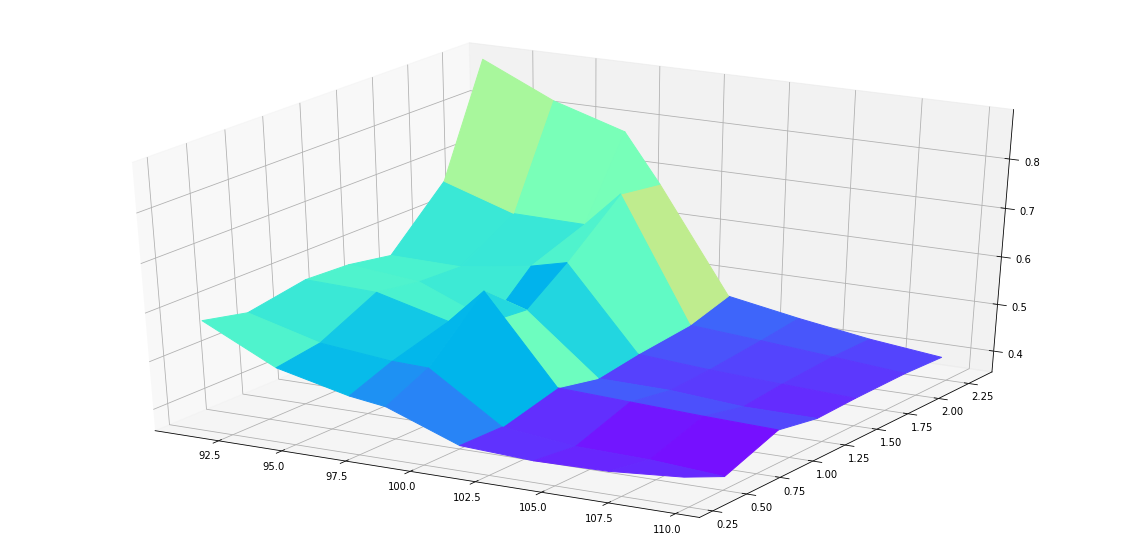

In [55]:
PF = Payoff()
BS1 = BlackScholes("call", 0, 1, 356, 360, 0.02, 0.01, 10, 0, 0.3)
MP1 = [[12.00,14.50,18.25,20.45,20.75,16.20,12.40,9.30],
    [22.45,25.27,29.41,31.85,30.20,25.05,21.05,17.04],
    [33.57,38.00,40.83,47.50,41.75,37.15,32.90,29.10],
    [38.45,42.57,43.80,48.83,46.20,42,37.35,33.80],
    [40.43,45.70,52.87,56.96,52,47.40,43.20,39.25],
    [47.52,51.20,57.65,65.35,57.45,53.50,49.45,45.30],
    [54.48,59.22,64.80,63.80,61.20,56.80,52.5,48.50]] 
K1 = [325,335,345,350,360,370,380,390]
T1 = [0.3,0.6,1,1.3,1.6,2,2.3]
BS1.plot_impliedvol(strikes=K1, maturitys=T1, market_prices=MP1)

83.90241599082947


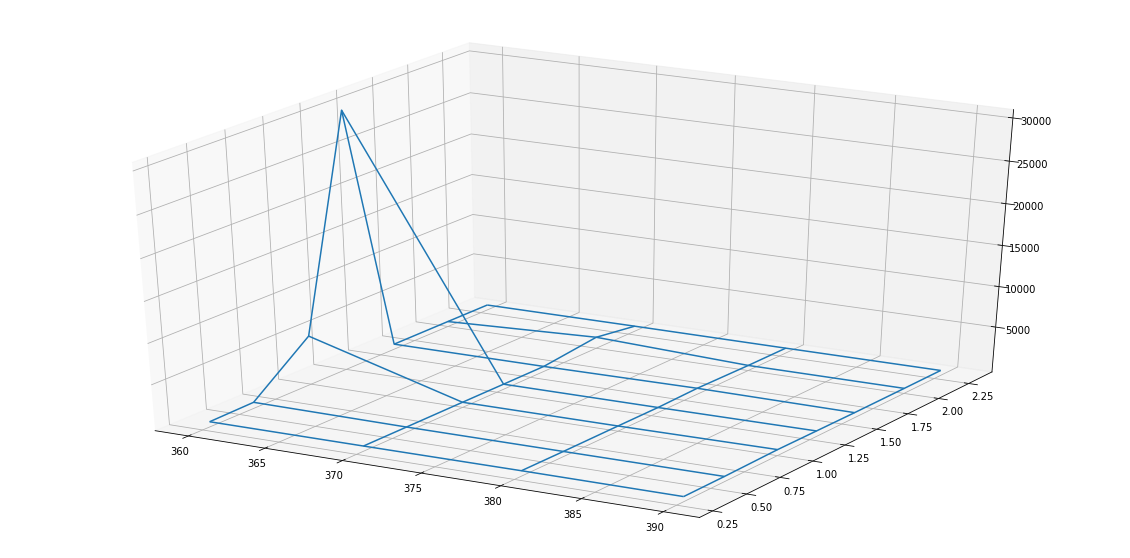

In [10]:
PF = Payoff()
BS = Black
market_prices = [[20.75,16.20,12.40,9.30],
                [30.20,25.05,21.05,17.04],
                [41.75,37.15,32.90,29.10],
                [46.20,42,37.35,33.80],
                [52,47.40,43.20,39.25],
                [57.45,53.50,49.45,45.30],
                [61.20,56.80,52.5,48.50]] 
strikes = [360,370,380,390]
maturitys = [0.3,0.6,1,1.3,1.6,2,2.3]
plot_impliedvol_heston(PF.call,nature="call", time_spot=0, maturity=maturitys, spot_price=357, strike=strikes, 
                rate=0.02, dividends=0.01, market_price=market_prices, vega=0, sigmavol=0.01,
                rho=0, kappa=1, theta=0.1, initial_variance=0.02)

In [ ]:
PF = Payoff()
H=Heston('call',time_spot=0, maturity=10/365, spot_price=100, strike=100, rate=0.02, dividends=0, market_price=3, vega=0, sigmavol=0.15,
                rho=-0.7, kappa=1, theta=0.05, initial_variance=0.1)
print(H.price(PF.call))

In [9]:
PF = Payoff()
H=Heston("Call", 0, 1, 100, 110, 0.02, 0, 5, 0, 0, 0, 1, 0, 0.3)
print(H.price(PF.call))

(13.82236331185184, [13.254580590528237, 14.390146033175442], 16.234651803970337)


In [12]:
BS = BlackScholes("call",0,1,100,110,0.02,0,5,0,0.3)
print(BS.bs_call())
BS.price(Payoff().call)


8.864155948338997


(8.858459756160228, [8.848718562447559, 8.868200949872897], 217.12958073616028)

In [24]:
def plot_impliedvol(nature, time_spot, maturity, spot_price, strike, rate, dividends, market_price, vega, sigma):
    """
    args : 
        nature (str) : 'call' or 'put'
        time_spot (double)
        maturity (liste) : liste des maturités pour la nappe
        spot_price (double):prix spot
        strike (liste) : liste des strikes 
        rate (double)
        div (double)
    """
    IV = []
    for m in range(len(maturity)):
        IV.append([BlackScholes(nature, time_spot, maturity[m], spot_price, strikes[s], rate, dividends, 
                                   market_price[m][s], vega, sigma).vanilla_impliedvol(nature) for s in range(len(strikes))])
    
    z = np.array(IV)
    x, y = np.meshgrid(strikes, maturitys)
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(x, y, z)
    plt.show()

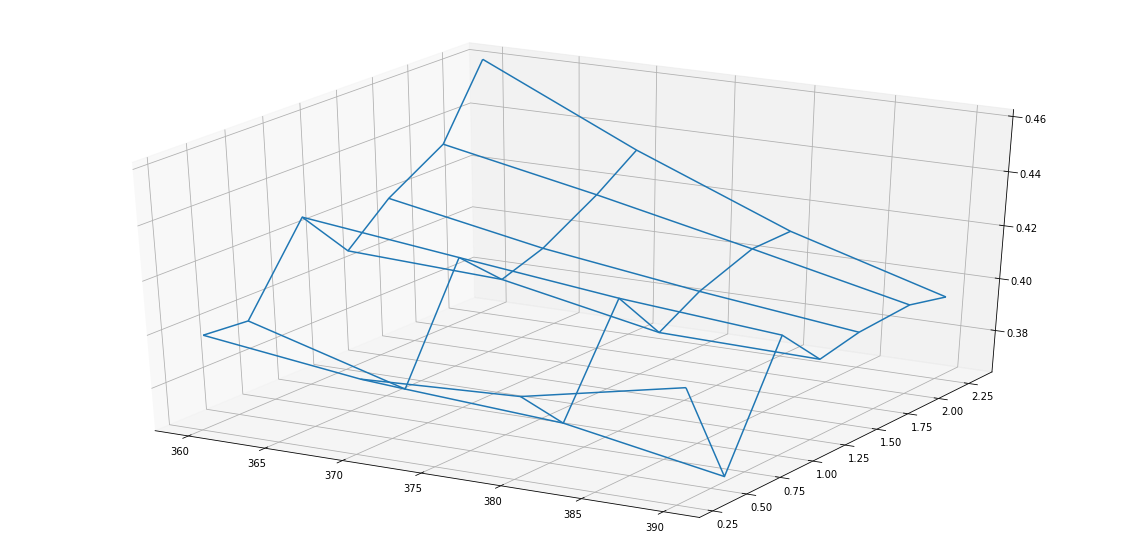

In [45]:
market_prices = [[20.75,16.20,12.40,9.30],
                [30.20,25.05,21.05,17.04],
                [41.75,37.15,32.90,29.10],
                [46.20,42,37.35,33.80],
                [52,47.40,43.20,39.25],
                [57.45,53.50,49.45,45.30],
                [61.20,56.80,52.5,48.50]] 
strikes = [360,370,380,390]
maturitys = [0.3,0.6,1,1.3,1.6,2,2.3]
plot_impliedvol(nature="call", time_spot=0, maturity=maturitys, spot_price=356, strike=strikes, 
                rate=0.02, dividends=0.01, market_price=market_prices, vega=0, sigma=0.3)

# Ne pas oublier qu'il y à un prix de marché pour chaque couple (Ki,Ti) !!!!
à faire 

In [60]:
PF=Payoff()
B=BlackScholes(nature="Call",time_spot=0,maturity=1, spot_price=279.80, strike=250, rate=0.00459, 
                dividends=0, market_price=25, vega=0, sigma=0.31)
print(B.price(PF.call))
IV=B.impliedvol(PF.call)
print(strike,IV)

(50.89965766432885, [49.72790211078687, 52.07141321787083], 0.18154382705688477)
[150, 200, 220, 250, 300] 3.944304526105059e-31


In [72]:
class VanillaPricer(Payoff, Diffusion):
    """
    This class bring some tools for pricing vanilla option. 
    This class herite from Payoff and Diffusion.
    """
    def __init__(self, model):
        self.model = model
    
    def price_uniasset(self, payoff, spot, K, rate, sigma, time_spot, maturity, nb_steps, nb_sim, alpha, model='BS'):
        """
        Pricer using montecarlo method for estimate vanilla price of optionswith one underliying
        Args : 
            payoff (Payoff) : payoff method from class Payoff
            spot (double) : spot price of the underliying 
            K (double) : Strike 
            rate (double) : interest rate
            sigma (double) : barrier down
            time_spot (double) : time spot (years)
            maturity (double) : time of maturity (years)
            nb_steps (int) : number of step in each brownian trajectory simulation 
            nb_sim (int) : number of simulation of trajectory
            alpha (double) : stastistical alpha for tje confidence interval
            model (string) : the model of pricing
            
        Return :
            (price, [C1,C2], time) (tuple): tuple containe price, confidence interval and time of calulation  
        """
        esp = 0
        espsquare = 0
        q_alpha = scipy.stats.norm.ppf(alpha)
        start=time()
        for i in self.generator(nb_sim):
            X = spot*np.exp((rate-0.5*sigma**2)*(maturity-time_spot)+sigma*np.sqrt(maturity-time_spot)*np.random.normal(0, 1))
            esp += payoff(X,K)
            espsquare += payoff(X,K)**2
        esp = np.exp(-rate*(maturity-time_spot))*esp/nb_sim
        var = (1/(nb_sim-1))*espsquare-(nb_sim/(nb_sim-1))*(esp**2)
        confidence = [esp-q_alpha*np.sqrt(var/nb_sim),esp+q_alpha*np.sqrt(var/nb_sim)]
        end=time()-start
        return(esp, confidence, end)

In [74]:
class ExoticPricer(Diffusion, Payoff):
    """
    This class bring some tools for pricing exotic options. 
    This class herite from Payoff and Diffusion.
    """
    def __init__(self, model):
        self.model = model
    
    def montecarlo(self, payoff, spot, K, rate, sigma, time_spot, maturity, nb_steps, nb_sim, alpha, bar_up = 110, bar_down = 90,model='BS'):
        """
        Pricer using montecarlo method for estimate vanilla price of optionswith one underliying
        Args : 
            payoff (Payoff) : payoff method from class Payoff
            spot (double) : spot price of the underliying 
            K (double) : Strike 
            rate (double) : interest rate
            sigma (double) : barrier down
            time_spot (double) : time spot (years)
            maturity (double) : time of maturity (years)
            nb_steps (int) : number of step in each brownian trajectory simulation 
            nb_sim (int) : number of simulation of trajectory
            alpha (double) : stastistical alpha for tje confidence interval
            B_up (double) : barrier up
            B_down (double) : barrier down
            model (string) : the model of pricing
            
        Return :
            (price, [C1,C2], time) (tuple): tuple containe price, confidence interval and time of calulation  
        """
        payoff_values=[]
        esp = 0
        espsquare = 0
        q_alpha = scipy.stats.norm.ppf(alpha)
        start=time()
        if model == "BS":
            for i in self.generator(nb_sim):
                ST= self.itodiffusion(spot, nb_steps, maturity-time_spot, b=lambda x,y: rate*y,s= lambda x,y: sigma*y)
                esp += payoff(ST,K,B_down=90)
                espsquare += payoff(ST,K,bar_up,bar_down)**2
        esp = np.exp(-rate*(maturity-time_spot))*esp/nb_sim
        var = (1/(nb_sim-1))*espsquare-(nb_sim/(nb_sim-1))*(esp**2)
        confidence = [esp-q_alpha*np.sqrt(var/nb_sim),esp+q_alpha*np.sqrt(var/nb_sim)]
        end=time()-start
        return (esp, confidence,end)

In [ ]:
dataprovider
gmr
bacardi
vak